In [309]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyproj import Proj, transform

plt.rcParams['font.family'] = 'Malgun Gothic'

In [310]:
#기본 정보
coord_std=pd.read_excel('./기본정보_위경도.xlsx')

#숙박 유형
pension=pd.read_excel("./숙박유형_관광펜션업.xlsx")
camping=pd.read_excel("./숙박유형_일반야영장업.xlsx")
hanok=pd.read_excel("./숙박유형_한옥체험업.xlsx")
resort=pd.read_excel("./숙박유형_호텔리조트.xlsx") 
rural=pd.read_excel('./숙박유형_농어촌숙박.xlsx')

#비대면
alien1=pd.read_csv('./비대면_외지인방문자수_1.csv',encoding='cp949')
alien2=pd.read_csv('./비대면_외지인방문자수_2.csv',encoding='cp949')
resider1=pd.read_csv('./비대면_현지인방문자수_1.csv',encoding='cp949')
resider2=pd.read_csv('./비대면_현지인방문자수_2.csv',encoding='cp949')

#식음및부대시설
meal=pd.read_csv('./부대시설_음식점.csv',encoding='cp949')
cafe=pd.read_csv('./부대시설_휴게음식점.csv',encoding='utf-8')

#콘텐츠
contents1=pd.read_csv('./콘텐츠_관광지_검색순위_상.csv',encoding='cp949')
contents2=pd.read_csv('./콘텐츠_관광지_검색순위_하.csv',encoding='cp949')

숙박유형

In [311]:
def accomm_preprocess(accomm):
    accomm.drop(accomm[(accomm['영업상태구분코드']!=1)].index,inplace=True)
    accomm=accomm[accomm['개방자치단체코드'].between(4800000,5010000)]
    accomm=accomm.loc[:,['개방자치단체코드','좌표정보(X)','좌표정보(Y)']]
    return accomm

ps=accomm_preprocess(pension)
cp=accomm_preprocess(camping)
hk=accomm_preprocess(hanok)
rs=accomm_preprocess(resort)

check_acco=len(ps)+len(cp)+len(hk)+len(rs)
print(check_acco)

990


In [312]:
proj_1 = Proj(init='epsg:2097')
proj_2 = Proj(init='epsg:4326')

def coordinate_transform(acco):
    convert = transform(proj_1, proj_2, acco['좌표정보(X)'].values, acco['좌표정보(Y)'].values)
    acco['경도'] = convert[0]
    acco['위도'] = convert[1]
    return acco

ps=coordinate_transform(ps)
cp=coordinate_transform(cp)
hk=coordinate_transform(hk)
rs=coordinate_transform(rs)

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\user\AppData\Local\Temp\ipykernel_130820\3384813550.py:5: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotcha

In [313]:
accomm_df=pd.concat([ps,cp,hk,rs],ignore_index=True)
accomm_df.drop(['좌표정보(X)','좌표정보(Y)'],axis=1,inplace=True)

In [314]:
accomm_num=accomm_df.dropna(axis=0)
acco_n=accomm_num['개방자치단체코드'].value_counts() #지역별 숙소 개수
print(acco_n)

개방자치단체코드
4810000    268
4820000    143
4890000     70
4830000     52
4930000     44
4940000     43
4800000     39
4920000     37
4870000     28
4850000     27
4980000     27
5010000     27
4880000     26
4950000     25
4860000     20
4910000     17
4970000     17
4990000     17
4900000     13
4840000     11
4960000      9
5000000      7
Name: count, dtype: int64


부대시설

In [315]:
def cafe_preprocess(cafe):
    cafe.drop(cafe[(cafe['영업상태명']!='영업/정상')].index,inplace=True)
    #cafe=cafe.loc[:,['좌표정보(X)','좌표정보(Y)']]
    return cafe

cafe_preprocess(cafe)
cafe_df=coordinate_transform(cafe)
cafe_df

C:\Users\user\AppData\Local\Temp\ipykernel_130820\3384813550.py:5: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  convert = transform(proj_1, proj_2, acco['좌표정보(X)'].values, acco['좌표정보(Y)'].values)


,영업상태명,상세영업상태명,소재지전체주소,도로명전체주소,도로명우편번호,업태구분명,좌표정보(X),좌표정보(Y),경도,위도
0,영업/정상,영업,전라남도 목포시 상동 743-5,"전라남도 목포시 상리로1번길 25, 1층 (상동)",58642.0,일반조리판매,146327.6384,146229.9081,126.411313,34.813277
1,영업/정상,영업,전라남도 목포시 용당동 1050-8,"전라남도 목포시 영산로245번길 20, 2동 (용당동)",58652.0,커피숍,144316.9406,145266.4048,126.389403,34.804485
2,영업/정상,영업,전라남도 목포시 산정동 1753,"전라남도 목포시 원산중앙로 7, 3층 (산정동)",58638.0,기타 휴게음식점,142634.6637,145570.1962,126.370999,34.807129
3,영업/정상,영업,전라남도 목포시 산정동 1732,"전라남도 목포시 원산중앙로 51, 127,128호 (산정동)",58637.0,커피숍,142947.2016,145866.4413,126.374394,34.809817
4,영업/정상,영업,전라남도 목포시 대의동2가 1-80,"전라남도 목포시 영산로29번길 9-2, 1,2층 (대의동2가)",58729.0,커피숍,143301.0162,143394.6064,126.378427,34.787557
...,...,...,...,...,...,...,...,...,...,...
19229,영업/정상,영업,전라남도 신안군 비금면 도고리 175-41,NaN,NaN,기타 휴게음식점,105729.8085,141454.7863,125.968188,34.767291
19230,영업/정상,영업,전라남도 신안군 증도면 병풍리 1125 주3동 1층,NaN,NaN,커피숍,126805.8142,159316.9789,126.196823,34.930016
19231,영업/정상,영업,전라남도 신안군 임자면 대기리 2523-30 튤립공원 유리온실,"전라남도 신안군 임자면 대광해수욕장길 182-34, 튤립공원 유리온실",58803.0,커피숍,115655.6986,178739.8707,126.072830,35.104200
19232,영업/정상,영업,전라남도 신안군 암태면 단고리 28-1,"전라남도 신안군 암태면 중부로 1816, 주3동 소매점동",58836.0,편의점,118906.8455,148124.0262,126.111463,34.828534


매력 요소: 비대면 지수, 외부 유입 지수

          비대면지수      외부유입지수  숙소개수
지역                               
목포시   41.232053 -36120715.5   268
여수시   49.405687 -27693993.5   143
순천시   43.061186 -34299431.0    70
나주시   62.008706 -10008175.0    52
광양시   49.087961 -14126210.0    44
담양군  164.141395   6075746.5    43
곡성군  111.218072    574927.5    39
구례군  117.905852    904697.0    37
고흥군   69.595750  -2972475.0    28
보성군   98.632132    -98513.0    27
화순군   84.238047  -2341198.5    27
장흥군   58.054895  -3816795.5    27
강진군   70.229029  -2399610.5    26
해남군   73.605863  -3163934.0    25
영암군   80.345210  -2547058.5    20
무안군   79.961388  -3741836.0    17
함평군  136.376471   1713952.0    17
영광군   62.530661  -4386753.0    17
장성군  124.785514   2058376.5    13
완도군   52.339439  -5384338.0    11
진도군   90.278926   -538942.0     9
신안군  122.562591   1275741.0     7


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


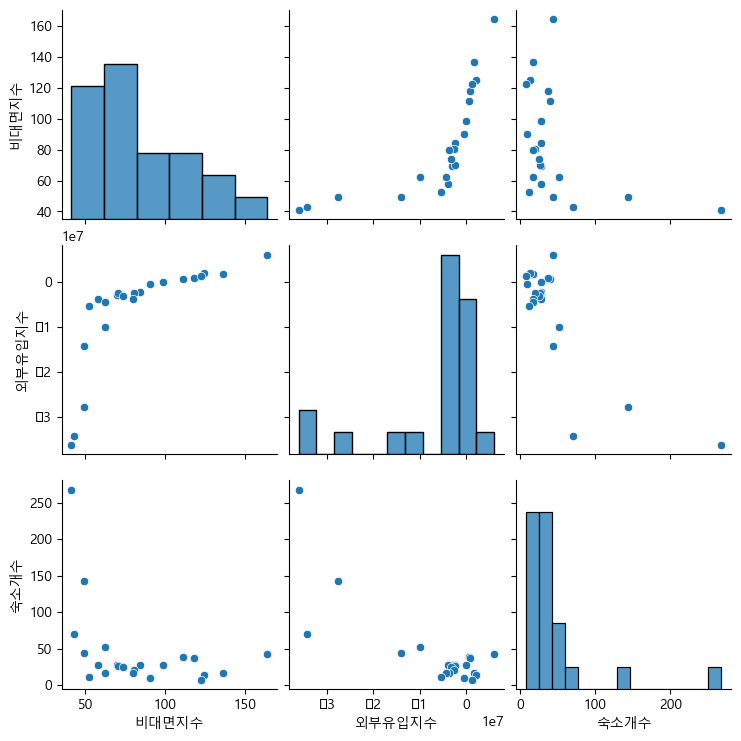

In [316]:
alien=pd.concat([alien1,alien2],axis=1,ignore_index=True)
alien.drop([2],axis=1,inplace=True) #순위 제거
alien['평균외지인방문자수']=(alien[1]+alien[3])/2 

resider=pd.concat([resider1,resider2],axis=1,ignore_index=True)
resider.drop([2],axis=1,inplace=True)
resider['평균현지인방문자수']=(resider[1]+resider[3])/2

regions=alien[0]

calm_score=alien['평균외지인방문자수']/resider['평균현지인방문자수']*100 #선행연구 참고
induce_score=alien['평균외지인방문자수']-resider['평균현지인방문자수']

attract_df=pd.concat([regions,calm_score,induce_score],axis=1)
attract_col=['지역','비대면지수','외부유입지수']
attract_df.columns=attract_col
attract_df.set_index('지역',inplace=True)

acco_n_fr=list(acco_n).copy()
attract_df['숙소개수']=acco_n_fr

print(attract_df)

attract_df.corr() #둘 다 0.717266
sns.pairplot(attract_df) #조용한 곳일수록 유입이 많다.

콘텐츠

In [317]:
contents2.drop('광역시/도',axis=1,inplace=True)

In [318]:
count_num=0
sites=[]
rnum=[]

for i in range(len(contents2)): #22'09~23'08
   for j in range(len(contents1)): #21'09~22'08
        if contents2['관광지명'][i]==contents1['관광지명'][j]:
            count_num+=1
            sites.append(contents2['관광지명'][i])
            rnum.append(contents2['검색건수'][i])

print(count_num) #451: 인기 관광지 500곳 중 451곳은 반복해서 수요가 많다.
print(sites) #사람들이 반복해서 찾는 곳

451
['순천만국가정원', '목포역', '순천역', '죽녹원', '오동도', '여수해상케이블카놀아정류장', 'LF스퀘어광양점', '완도항여객선터미널', '향일암', '목포해상케이블카북항승강장', '아쿠아플라넷여수', '여수엑스포역', '목포종합버스터미널', '화엄사', '나주역', '여수예술랜드', '목포연안여객선터미널', '녹동항', '롯데아울렛남악점', '백양사', '여수공항', '메타프로방스', '순천종합버스터미널', '순천만습지', '낙안읍성민속마을', '섬진강기차마을', '유월드루지테마파크', '율포해수욕장', '영광종합버스터미널', '선암사', '아르떼뮤지엄여수', '불갑사', '송광사', '진도항', '녹동신항연안여객선터미널', 'NC백화점순천점', '여수수산시장', '돌산공원', '무안CC', 'CGV순천신대', '장성역', '푸른솔GC', '무안국제공항', '호남해안로드4코스영광백수해안도로', '여수수산물특화시장', '대흥사', '벌교역', '목포항국제여객터미널', '골드레이크CC', '해남종합버스터미널', '담양관방제림', '사성암', '여수종합버스터미널', '여천역', '암태남강선착장', '중마버스터미널', '신지명사십리해수욕장', '무등산CC', '만성리검은모래해변', '메타세쿼이아가로수길', '구례구역', '순천아랫장', '운림산방', '순천오픈세트장', '아크로CC', '여수연안여객선터미널', '정남진장흥토요시장', '강진버스여객터미널', '신기항여객터미널', 'JNJ골프리조트', '소쇄원', '갓바위', '함평엘리체CC', '나로우주센터우주과학관', '천은사', '진남관공사중(2023년12월완공예정)', '땅끝전망대', '골프존카운티순천', '돌머리해변', '무안시외버스터미널', '목포북항', '땅끝선착장', '여수구항방파제등대', '목포근대역사관1관', '청호시장', '다산베아채CC', '파인비치골프링크스', '목포종합수산시장', '화순CC', '웅천친수공원', '광주CC', '메타세콰이어길', '사우스링스영암CC짐앵', '파인힐

Text(0.5, 1.0, '전라남도 관광지 검색량')

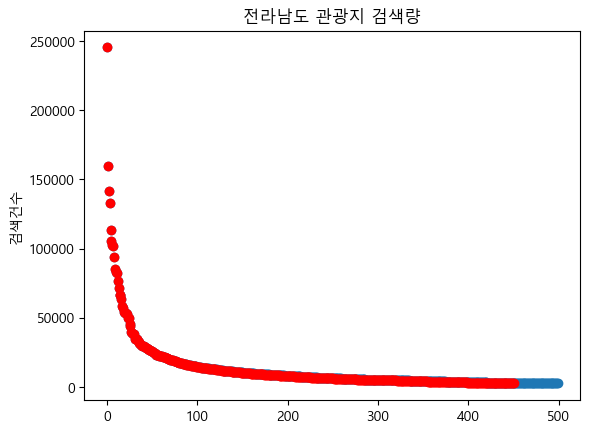

In [319]:
x1=np.arange(len(contents2))
plt.scatter(x1,contents2['검색건수'])
x2=np.arange(len(rnum))
plt.scatter(x2,rnum,c='r')

plt.ylabel('검색건수')
plt.title('전라남도 관광지 검색량') #가는 곳(만) 또 감

In [320]:
ct2=contents2.drop_duplicates(subset=['시/군/구'])
contents_df=ct2.drop(['중분류 카테고리','순위','관광지명','도로명주소'], axis=1).reset_index(drop=True)
print(contents_df)

   시/군/구     소분류 카테고리    검색건수
0    순천시         기타관광  245254
1    목포시         교통시설  159899
2    담양군         자연공원  132973
3    여수시  자연경관(하천/해양)  113284
4    광양시          쇼핑몰  102492
5    완도군         교통시설  101505
6    구례군         종교성지   71502
7    나주시         교통시설   66728
8    고흥군  자연경관(하천/해양)   58260
9    무안군          쇼핑몰   57042
10   장성군         종교성지   54430
11   곡성군         기타관광   45263
12   보성군  자연경관(하천/해양)   39860
13   영광군         교통시설   39224
14   진도군  자연경관(하천/해양)   34692
15   해남군         종교성지   27724
16   신안군         교통시설   23194
17   화순군      육상레저스포츠   22783
18   영암군      육상레저스포츠   21308
19   장흥군           시장   20611
20   강진군         교통시설   20606
21   함평군      육상레저스포츠   19333


데이터 취합

In [321]:
diff=meal['항목'].compare(contents_df['시/군/구'])
print(diff)

   self other
0   여수시   순천시
1   순천시   목포시
2   목포시   담양군
3   광양시   여수시
4   나주시   광양시
5   무안군   완도군
6   해남군   구례군
7   영암군   나주시
9   화순군   무안군
10  완도군   장성군
11  담양군   곡성군
12  영광군   보성군
13  보성군   영광군
14  장성군   진도군
15  장흥군   해남군
16  강진군   신안군
17  구례군   화순군
18  신안군   영암군
19  진도군   장흥군
20  곡성군   강진군


In [322]:
visit=[]

for i in range(len(meal)):
    for j in range(len(contents_df)):
        if meal['항목'][i]==contents_df['시/군/구'][j]:
            visit.append(contents_df['검색건수'][j])

print(visit)

[113284, 245254, 159899, 102492, 66728, 57042, 27724, 21308, 58260, 22783, 101505, 132973, 39224, 39860, 54430, 20611, 20606, 71502, 23194, 34692, 45263, 19333]


In [323]:
visit_num=pd.DataFrame(visit)
meal['검색건수']=visit

meal_columns=['항목','음식점개수','경도','위도','검색건수']
meal.columns=meal_columns
meal.loc[0,'음식점개수']=3875
meal.loc[1,'음식점개수']=3157
meal.loc[2,'음식점개수']=2977
meal.loc[3,'음식점개수']=1974
meal.loc[4,'음식점개수']=1343
meal.loc[5,'음식점개수']=1016

print(meal)

     항목 음식점개수          경도         위도    검색건수
0   여수시  3875  127.662222  34.760374  113284
1   순천시  3157  127.483333  34.950000  245254
2   목포시  2977  126.350000  34.766667  159899
3   광양시  1974  127.695501  34.940548  102492
4   나주시  1343  126.716667  35.033333   66728
5   무안군  1016  126.481686  34.990454   57042
6   해남군   798  126.598927  34.573252   27724
7   영암군   696  126.696792  34.800169   21308
8   고흥군   689  127.284978  34.611222   58260
9   화순군   654  126.986480  35.064503   22783
10  완도군   610  126.755054  34.311060  101505
11  담양군   586  126.988167  35.321139  132973
12  영광군   582  126.511987  35.277172   39224
13  보성군   494  127.079894  34.771456   39860
14  장성군   476  126.784854  35.301833   54430
15  장흥군   444  126.906928  34.681686   20611
16  강진군   434  126.767261  34.642077   20606
17  구례군   419  127.462653  35.202495   71502
18  신안군   385  126.101074  34.827332   23194
19  진도군   376  126.243148  34.460868   34692
20  곡성군   314  127.291918  35.281955   45263
21  함평군   

In [324]:
sites_num=pd.DataFrame([76,41,40,26,25,19,25,12,16,23,18,
                        23,21,16,18,13,17,18,14,16,11,12])
tour_df=pd.concat([meal,sites_num],axis=1,ignore_index=True)
tour_col=['지역','음식점개수','경도','위도','검색건수','관광지개수']
tour_df.columns=tour_col
tour_df.set_index('지역',inplace=True)
tour_df.info()
attract_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22 entries, 여수시 to 함평군
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   음식점개수   22 non-null     object 
 1   경도      22 non-null     float64
 2   위도      22 non-null     float64
 3   검색건수    22 non-null     int64  
 4   관광지개수   22 non-null     int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 1.0+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 22 entries, 목포시 to 신안군
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   비대면지수   22 non-null     float64
 1   외부유입지수  22 non-null     float64
 2   숙소개수    22 non-null     int64  
dtypes: float64(2), int64(1)
memory usage: 1.2+ KB


In [336]:
a_index=attract_df.index
t_index=tour_df.index
calmness=[]
entranger=[]
accommodation=[]

for i in range(len(tour_df)):
    for j in range(len(attract_df)):
        if t_index[i]==a_index[j]:
            calmness.append(attract_df['비대면지수'][j])
            entranger.append(attract_df['외부유입지수'][j])
            accommodation.append(attract_df['숙소개수'][j])
        else:
            continue


tour_df['비대면지수']=calmness.copy()
tour_df['외부인유입지수']=entranger.copy()
tour_df['숙소개수']=accommodation.copy()

print(tour_df)

    음식점개수          경도         위도    검색건수  관광지개수       비대면지수     외부인유입지수  숙소개수
지역                                                                           
여수시  3875  127.662222  34.760374  113284     76   49.405687 -27693993.5   143
순천시  3157  127.483333  34.950000  245254     41   43.061186 -34299431.0    70
목포시  2977  126.350000  34.766667  159899     40   41.232053 -36120715.5   268
광양시  1974  127.695501  34.940548  102492     26   49.087961 -14126210.0    44
나주시  1343  126.716667  35.033333   66728     25   62.008706 -10008175.0    52
무안군  1016  126.481686  34.990454   57042     19   79.961388  -3741836.0    17
해남군   798  126.598927  34.573252   27724     25   73.605863  -3163934.0    25
영암군   696  126.696792  34.800169   21308     12   80.345210  -2547058.5    20
고흥군   689  127.284978  34.611222   58260     16   69.595750  -2972475.0    28
화순군   654  126.986480  35.064503   22783     23   84.238047  -2341198.5    27
완도군   610  126.755054  34.311060  101505     18   52.339439  -53

            음식점개수        경도        위도      검색건수     관광지개수     비대면지수   외부인유입지수  \
음식점개수    1.000000  0.397433 -0.090093  0.752511  0.914170 -0.594512 -0.943067   
경도       0.397433  1.000000  0.194568  0.406329  0.399860 -0.177396 -0.267448   
위도      -0.090093  0.194568  1.000000  0.068769 -0.066521  0.515137  0.183392   
검색건수     0.752511  0.406329  0.068769  1.000000  0.599145 -0.314661 -0.755710   
관광지개수    0.914170  0.399860 -0.066521  0.599145  1.000000 -0.452021 -0.779702   
비대면지수   -0.594512 -0.177396  0.515137 -0.314661 -0.452021  1.000000  0.717266   
외부인유입지수 -0.943067 -0.267448  0.183392 -0.755710 -0.779702  0.717266  1.000000   
숙소개수     0.764677  0.100846 -0.048719  0.572655  0.677216 -0.402532 -0.802870   

             숙소개수  
음식점개수    0.764677  
경도       0.100846  
위도      -0.048719  
검색건수     0.572655  
관광지개수    0.677216  
비대면지수   -0.402532  
외부인유입지수 -0.802870  
숙소개수     1.000000  


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


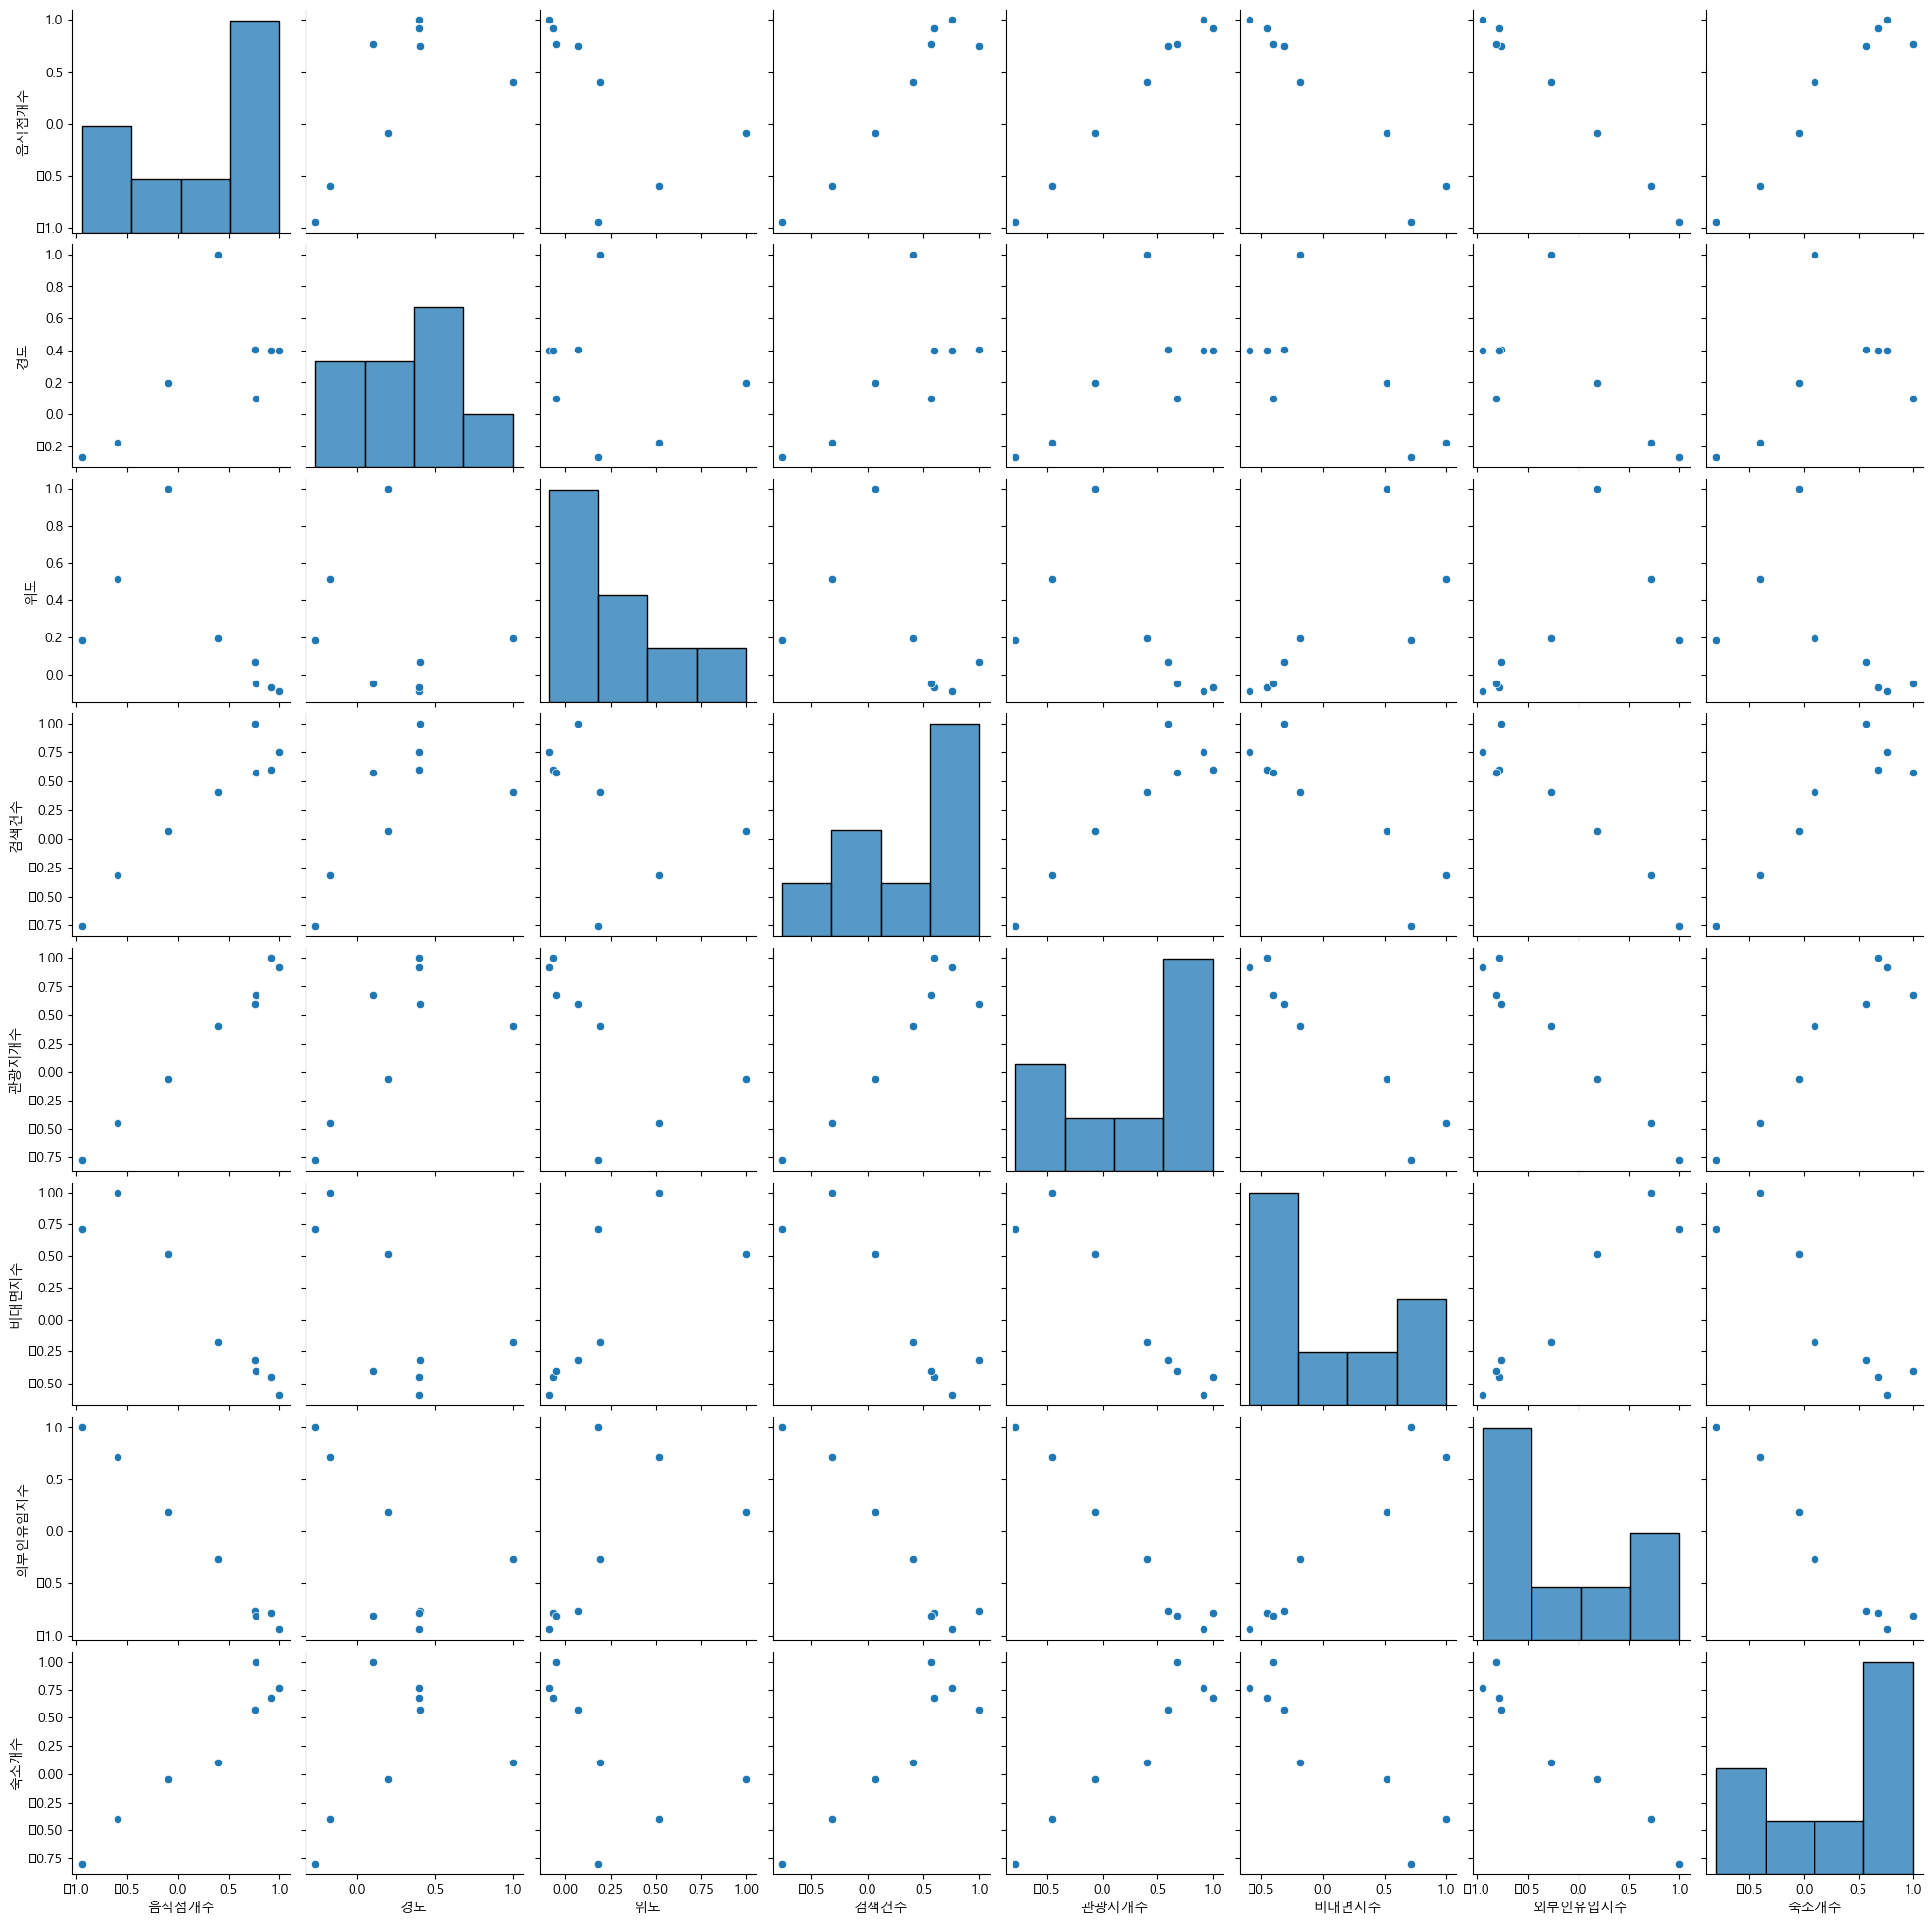

In [340]:
tour_corr=tour_df.corr()
print(tour_corr)

sns.pairplot(tour_corr)

#외부유입지수<-> (특히)음식점개수, 검색건수, 관광지개수
#-> 외지인은 덜 유명한 곳을 찾아간다?
#외부유입지수와 비대면지수는 상생

시각화

In [327]:
xmin=min(coord_std['경도'])
xmax=max(coord_std['경도'])
ymin=min(coord_std['위도'])
ymax=max(coord_std['위도'])

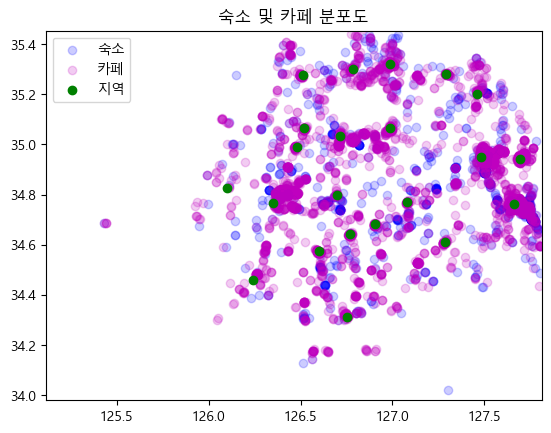

In [328]:
#숙소유형
plt.scatter(x=accomm_df['경도'],y=accomm_df['위도'],alpha=0.2,c='b',label='숙소')

plt.scatter(x=cafe['경도'],y=cafe['위도'],alpha=0.2,c='m',label='카페')

plt.scatter(x=tour_df['경도'],y=tour_df['위도'],c='g',label='지역')


plt.title('숙소 및 카페 분포도')

plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

plt.legend()

plt.show()